- Proportional 

Clusters:



In [1]:
import pdb
import random
from collections import OrderedDict
from imp import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import SVG, display
from sklearn.decomposition import PCA

from acs import ACSCountyReader, read_merge_acs
from hud_geo_conversions import read_zips_to_fips
from jdata import JData
from jdata_counties import JDataCounties
from map_maker import draw_county_data_svg
from probplots import plot_dists_pps
from religion_census import read_judaic_cngs
from utilities import (display_cb, is_outlier_instance, is_outlier_val,
                       read_fips_codes)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

%matplotlib inline

SEED = 42
random.seed(SEED)

In [2]:
DATA_DIR    = '../Data/'
IMG_DIR = '../Images/'

DEM_DIR = ''.join([DATA_DIR, 'Demography/'])
SCL_DIR = ''.join([DATA_DIR, 'Schools/'])
REL_DIR  = ''.join([DATA_DIR, 'Religion/'])

ZIPS_TO_FIPS_FP = ''.join([DATA_DIR, 'ZIP_COUNTY_122016.xlsx'])
FIPS_TO_ZIPS_FP = ''.join([DATA_DIR, 'COUNTY_ZIP_122016.xlsx'])
FIPS_CODES_FP   = ''.join([DATA_DIR, 'Census-2010-County-FIPS.txt'])

# ACS data files
POP_FP           = ''.join([DEM_DIR, 'ACS_15_5YR_B01003/',
                            'ACS_15_5YR_B01003_with_ann.csv'])
FOREIGN_BIRTH_FP = ''.join([DEM_DIR, 'ACS_15_5YR_B05006/', 
                                'ACS_15_5YR_B05006_with_ann.csv'])
SNGL_ANCE_FP     = ''.join([DEM_DIR, 'ACS_15_5YR_B04004/',
                            'ACS_15_5YR_B04004_with_ann.csv'])
MULT_ANCE_FP     = ''.join([DEM_DIR, 'ACS_15_5YR_B04005/',
                           'ACS_15_5YR_B04005_with_ann.csv'])
ALL_ANCE_FP      = ''.join([DEM_DIR, 'ACS_15_5YR_B04006/',
                            'ACS_15_5YR_B04006_with_ann.csv'])

# US Religion Census data files
RELCEN_CB_FP  = ''.join([REL_DIR, 'US-Religion-Census-2010-County-File-CB.TXT'])
RELCEN_FP = ''.join([REL_DIR, 'US-Religion-Census-2010-County-File.DTA'])

# JData.org data file
JDATA_FP = ''.join([SCL_DIR, 'jdata_directory.json'])

DAY_CENSUS_PDF_FP = ''.join([SCL_DIR, 'Census-Jewish-Day-Schools-2013-14.pdf'])
DAY_CENSUS_FP = ''.join([SCL_DIR, 'Census-Jewish-Day-Schools-2013-14.csv'])

# zip_to_fips =  read_zips_to_fips(ZIPS_TO_FIPS_FP)
# fips_codes = read_fips_codes(FIPS_CODES_FP)

## JData vs Religious Census

In [3]:
relcen = read_judaic_cngs(RELCEN_FP, standard_cols=False)
jdc = JDataCounties(JDATA_FP, ZIPS_TO_FIPS_FP)
jd_fips = jdc.get_county_cnts(categorical='denom', include=['PTSch'])
jd_fips.head()

,Denom_Orth,Denom_Seph,Denom_Trad,Denom_Consv,Denom_Recon,Denom_Ref,Denom_Comm,Denom_PlurTrans,Denom_Hum,Denom_Sec,Denom_Oth
FIPS,,,,,,,,,,,
01045,0.000,0.000,0.000,0.000,0.000,0.080,0.000,0.000,0.000,0.000,0.000
01069,0.000,0.000,0.000,0.000,0.000,0.920,0.000,0.000,0.000,0.000,0.000
01073,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
01081,0.000,0.000,0.000,0.000,0.000,0.987,0.000,0.000,0.000,0.000,0.000
01087,0.000,0.000,0.000,0.000,0.000,0.013,0.000,0.000,0.000,0.000,0.000


How do JData and Religious Census relate to each other?

- Is there any duplication of data between JData and Religious Census?
- Are most Part-time schools in Synagogues?

_Answer_:
- Yes, with the exception of Orthodox which makes sense since those would not be in the JData database
- 

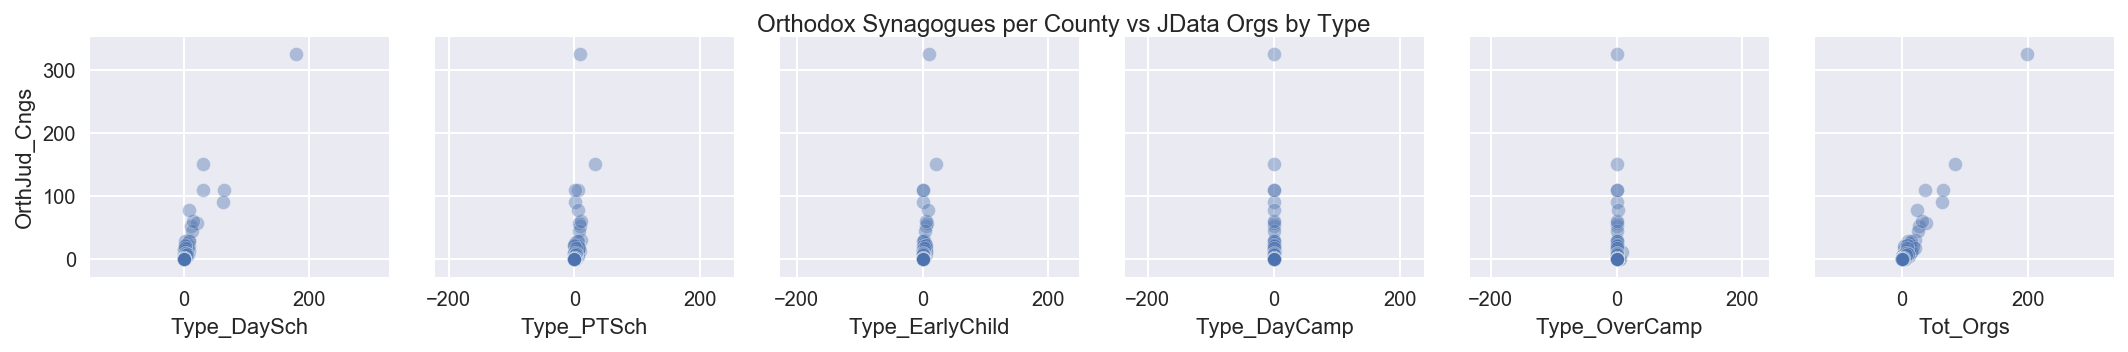

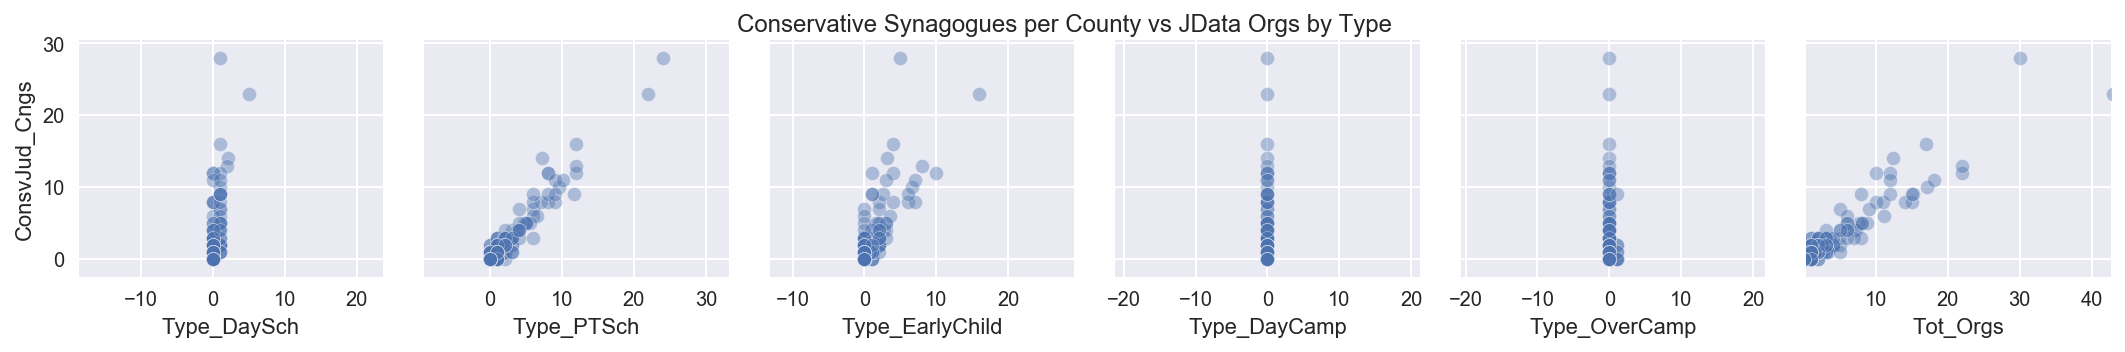

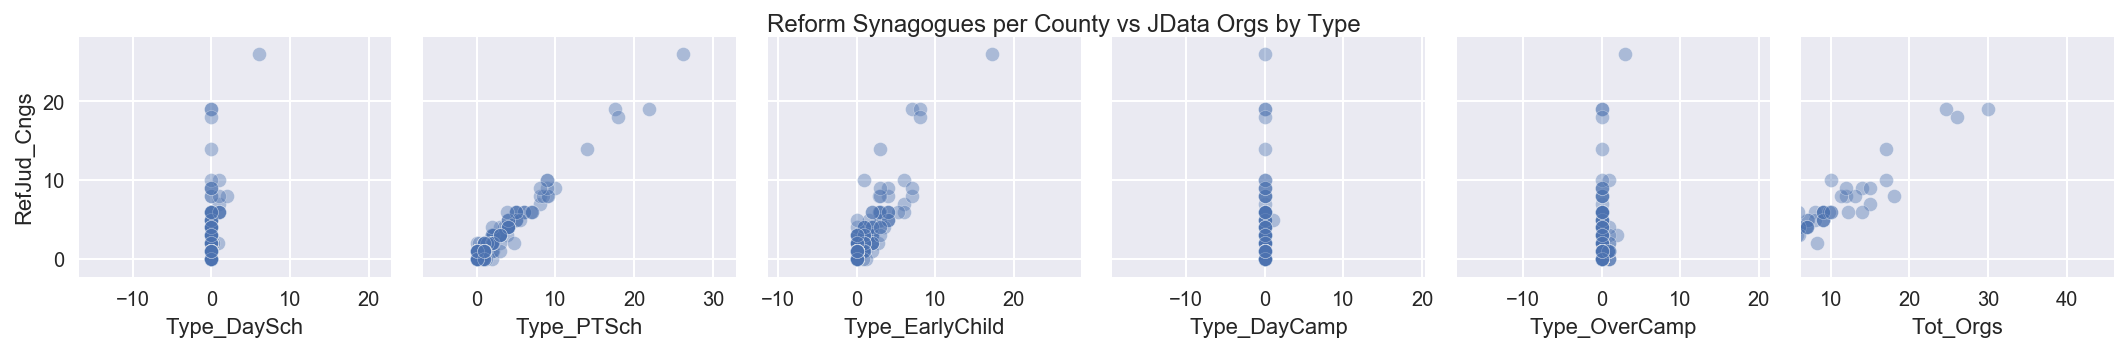

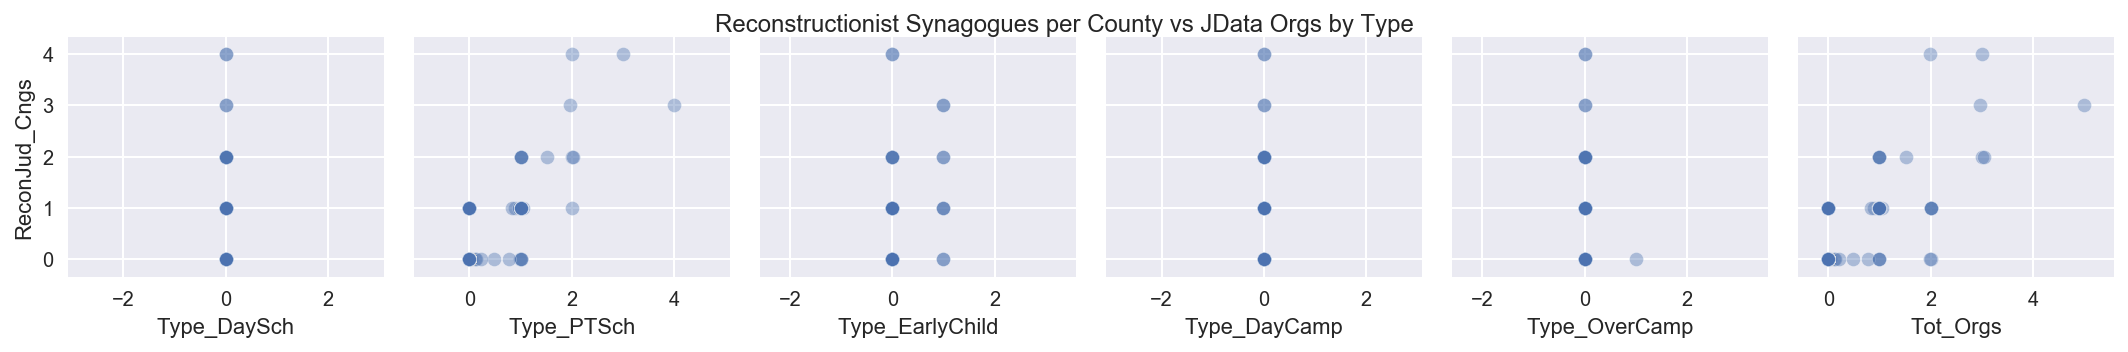

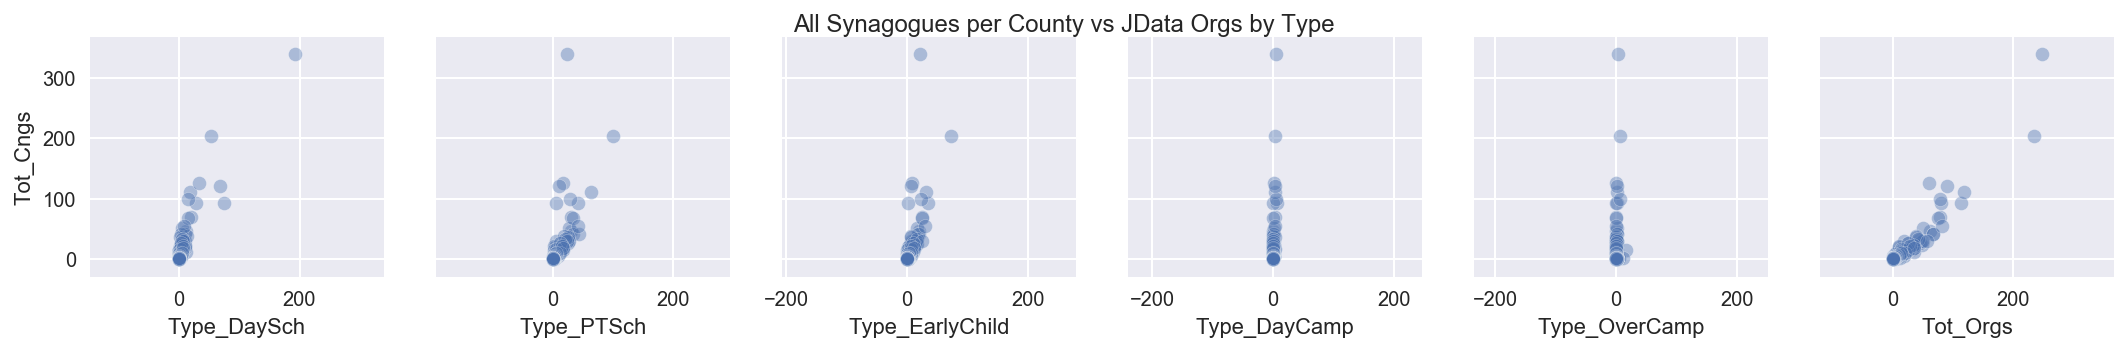

In [4]:
def plot_synagogues_vs_jdata_orgs(jdc, relcen, **kwargs):
    """Compare synagogues and JData organization counts per county.
    
    Parameters
    ----------
    jdc : JDataCounties instance
    relcen : DataFrame, Religious Census data on Judaic denoms.
    **kwargs: keyword arguments passed to sns.pairplot.
    """
    denom_names = ('Orthodox', 'Conservative', 'Reform',
                   'Reconstructionist', 'All')
    jdata_orgs  = ('Orth', 'Consv', 'Ref', 'Recon', 'Tot_Orgs')
    relcen_cngs = ('OrthJud_Cngs', 'ConsvJud_Cngs',
                   'RefJud_Cngs', 'ReconJud_Cngs', 'Tot_Cngs')
    types = ('Type_DaySch', 'Type_PTSch', 'Type_EarlyChild',
             'Type_DayCamp', 'Type_OverCamp')
    relcen = relcen.assign(Tot_Cngs=relcen.sum(1))
    
    for name, org, cng in zip(denom_names, jdata_orgs, relcen_cngs):
        include = org if org != 'Tot_Orgs' else None
        jd = jdc.get_county_cnts(categorical='type', include=include)
        
        # so that all types are plotted even if they don't
        # exist for a denomination
        jd = jd.reindex(columns=types, fill_value=0)
        
        jd = jd.assign(Tot_Orgs=jd.sum(1))
        data = jd.join(relcen, how='outer').fillna(0)
        grid = sns.pairplot(data, y_vars=cng, x_vars=jd.columns.tolist(),
                            **kwargs)
        
        title = '{} Synagogues per County vs JData Orgs by Type'.format(name)
        grid.fig.suptitle(title)
        
        # Make scatter plots comparable across types
        for ax in grid.axes[0]:
            ax.axis('equal')
        
        grid.fig.tight_layout(pad=1.5)

plot_synagogues_vs_jdata_orgs(jdc, relcen, plot_kws=dict(alpha=.4))

## ACS vs Congregants and Students

- Congregants are taken from the Religion Census, where authors estimated number of congregants
- Students are estimated with average student per school denomination from Day School Census

## Merge Tables

Important variables:
- Number of synagogues
- Number of schools
- Number of Jewish people (ancestry is proxy)

Not using:
- Number of congregants
    - Already have a proxy for number of Jews with ancestry.
    - Regardless of the size of the synagogue, one could assume capacity would not be an issue for someone interested in learning Hebrew there. We would be looking for those ... supply-demand imbalance

Scaling methodology

- Try LDA, Factor Analysis

In [5]:
from imp import reload
import jdata_counties
reload(jdata_counties)
from jdata_counties import JDataCounties, JData

jdc = JDataCounties(JDATA_FP, ZIPS_TO_FIPS_FP)
jd_fips = jdc.get_county_cnts(exclude=['DayCamp', 'OverCamp'],
                              combine_denoms=True)

jd_type, jd_denom = jd_fips.iloc[:, :3], jd_fips.iloc[:, 3:]

In [6]:
jd_type.head()

,Type_DaySch,Type_PTSch,Type_EarlyChild
FIPS,,,
01045,0.000,0.080,0.000
01069,0.000,0.920,0.000
01073,1.000,3.000,3.000
01081,0.000,0.987,0.000
01087,0.000,0.013,0.000


In [7]:
pop_df = ACSCountyReader(POP_FP).read_counties(geo=True)
pop_df.head()

NameError: name 'x' is not defined

In [ ]:
def to_not_born_isr(df, ance_col='Ance_Isr', born_col='Born_Isr'):
    """Converts Israeli ancestry to subset: those not born there."""
#     return  df
    diff = df[ance_col] - df[born_col]
    df.loc[:, ance_col] = diff
    df = df.rename(columns={ance_col: 'NonBorn_Isr'})
    return df

params = [
    dict(name='Ance_Isr', kw='Israeli', fp=ALL_ANCE_FP),
    dict(name='Born_Isr', kw='Israel',  fp=FOREIGN_BIRTH_FP),
    ]

acs_df = read_merge_acs(params)

In [ ]:
relcen = (read_judaic_cngs(RELCEN_FP, standard_cols=False)
#           .drop(['UnionMessJews_Cngs'], axis=1)
)

In [ ]:
counties = pd.concat([jd_fips, relcen, acs_df], axis=1).fillna(0)

In [ ]:
counties.head()

In [ ]:
data = (pop_df.join(counties, how='right')
        .assign(Tot_Orgs=counties.loc[
            'Type_DaySch': 'RefJud_Cngs'].sum(1))
)

data = (data.loc[:, ['County', 'State', 'Tot', 'Tot_Orgs']]
        .assign(Isr_per_Org=(counties.Ance_Isr/data.Tot_Orgs).replace(np.inf, 0).fillna(0))
        .sort_values('Tot', ascending=False)
)

# outliers = pop_df.Tot[is_outlier_val(np.log(pop_df.Tot))]
# data = data.loc[~data.index.isin(outliers.index)]

In [ ]:
data.loc[data.Isr_per_Org<10].head()

In [ ]:
data.Isr_per_Org.replace(np.inf, 0).fillna(0).describe()

In [ ]:
sns.distplot(np.log(pop_df.Tot))

In [ ]:
data = counties
x_vars = (data.loc[:, 'Denom_Consv': 'Denom_Ref'].columns.tolist()
          + ['Ance_Isr', 'Born_Isr']
)
y_vars = data.loc[:, 'ConsvJud_Cngs': 'Born_Isr'].columns.tolist()
                
with sns.plotting_context('talk'):
    g = sns.pairplot(data=counties, x_vars=x_vars, y_vars=y_vars)

plt.show()

In [ ]:
# counties = counties.drop('Type_Early_childhood_center', axis=1)

In [ ]:
counties[counties.sum(1)==1].head()

In [ ]:
from sklearn_pandas import DataFrameMapper

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

class LogScaleByTotal(TransformerMixin):
    """Logs counts normalized by all count total."""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.log(X+1/np.sum(X+1))
    
class LogScaleBySubTotal(TransformerMixin):
    """Logs counts normalized by column total."""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        def f(x): return np.log(x+1/np.sum(x+1))
        return np.apply_along_axis(f, 1, X)
    
class LogStandardScaler(StandardScaler):
    """Standardized logged data."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def fit(self, X, y=None):
        return super().fit(np.log(X+1))
    
    def transform(self, X, y=None):
        return super().transform(np.log(X+1))

df = counties

scaler = LogScaleByTotal()
reducer = PCA()

pipe = Pipeline([
    ('scaler', scaler),
    ('reducer', reducer)
])
reduced = pipe.fit_transform(df)
print(reducer.explained_variance_ratio_)

# mapper = DataFrameMapper([
#     ([])
    
# ])

In [ ]:
plt.figure(figsize=(10, 10))
sns.jointplot(x=reduced[:, 0], y=reduced[:, 1],
          alpha=.2)

In [ ]:
# comps = pd.DataFrame(reducer.components_, columns=data.columns)
plt.figure(figsize=(10, 8))
sns.heatmap(reducer.components_.T, yticklabels=df.columns.tolist(), annot=True)

plt.title('Weights of features for decomposition')
plt.xlabel('Component')

plt.tight_layout();

In [ ]:
cnty_scl = pd.DataFrame(
    LogStandardScaler().fit_transform(counties),
    index=counties.index, columns=counties.columns)

In [ ]:
cnty_scl.describe()

In [ ]:
reducer = PCA(n_components=len(cnty_scl.T))
reducer.fit(cnty_scl)
reducer.explained_variance_ratio_.tolist()

In [ ]:
import hdbscan

In [ ]:
clust = hdbscan.HDBSCAN(min_cluster_size=5).fit(cnty_scl)

In [ ]:
plt.figure(figsize=(15, 10))
sns.countplot(clust.labels_)


In [ ]:
plt.figure(figsize=(5, 5))

sns.pairplot(data=data[data.cluster.isin(clust_n)], hue='cluster', )
plt.tight_layout()

In [ ]:
data = cnty_scl.assign(cluster=clust.labels_)

data = pd.melt(data, id_vars='cluster')

In [ ]:
with sns.plotting_context('talk'):
    sns.stripplot(data=data[data.cluster>-1], x='cluster', hue='variable', y='value',
                  jitter=.2, alpha=.9)

with sns.plotting_context('talk'):
    sns.pointplot(data=data[data.cluster>-2], x='cluster', hue='variable', y='value',)

In [ ]:
reduced = reducer.transform(cnty_scl)
reduced = pd.DataFrame(reduced)
data= pd.concatr([reduced, pd.DataFrame(clust.labels_, columns=['Label'])], axis=1).head()

In [ ]:
sns.jointplot(x=1, y=0, data=data, hue='Label')

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

for i in range(5, 10):
    clust = KMeans(20).fit(cnty_scl)
    score = silhouette_score(cnty_scl, clust.predict(cnty_scl))
    print(score)

# data = cnty[clust.labels_>-1]
# preds = clust.labels_[clust.labels_>-1]
# silhouette_score(data, preds)

In [ ]:
DIR = ''.join([IMG_DIR, 'play'])
colors = list(sns.color_palette('husl', len(np.unique(clust.labels_))).as_hex())
draw_county_data_svg(pd.Series(clust.labels_+1, index=cnty.index, name='clust'), DIR,
                     colors=colors, zero_color='#bebebe')

SVG(DIR)

In [ ]:
data = cnty.assign(cluster=clust.labels_)
sns.pointplot(x='cluster', y='Denom_Reform', data=data)

In [ ]:
ajpp_county = read_ajpp_county(AJPP_FP, AJPP_GEO_FP)

In [ ]:
data = (pd.DataFrame(clust.labels_, index=cnty.index, columns=['clust'])
        .join(ajpp_county))

sns.boxplot(x='clust', y='Jewish_By_Rel', data=data)
plt.semilogy();

In [ ]:
data = (pd.DataFrame(clust.labels_, index=cnty.index, columns=['clust'])
        .join(urb_rur))

sns.boxplot(x='clust', y='POPPCT_URBAN', data=data)

In [ ]:
data.groupby('pred').mean()

In [ ]:
data = cnty.assign(cluster=clust.labels_).groupby('cluster').count()
data

In [ ]:
data = (data
        .assign(cluster=clust.labels_).groupby('cluster').mean())
sns.heatmap(data=data)
plt.title('Compare Means of MinMaxScaled features.')

In [ ]:
data = (pd.DataFrame(MinMaxScaler().fit_transform(cnty),
                     columns=cnty.columns)
        .assign(cluster=clust.labels_).groupby('cluster').mean())
sns.heatmap(data=data)
plt.title('Compare Means of MinMaxScaled features.')

In [ ]:
from yellowbrick.features.rankd import Rank2D
from yellowbrick.features.radviz import RadViz
from yellowbrick.features.pcoords import ParallelCoordinates


visualizer = Rank2D(algorithm='covariance')

visualizer.fit(cnty)                # Fit the data to the visualizer
visualizer.transform(cnty)             # Transform the data
visualizer.poof();    # Draw/show/poof the data

In [ ]:
visualizer = ParallelCoordinates()

visualizer.fit(cnty.as_matrix(), np.random.randint(0, 5, 662))     # Fit the data to the visualizer
visualizer.transform(cnty)   # Transform the data
visualizer.poof()    ;     # Draw/show/poof the data

In [ ]:
rc_drop = ['County', 'State',
           'Tot_Cngs', 'Tot_No', 'Tot_Pc']

merged = (acs.join(urb_rur[['POPPCT_URBAN']])
          .join(jd_county, how='outer')
          .join(relcen.drop(rc_drop, axis=1), how='outer')
          .fillna(0))

In [ ]:
# dropping rows that are needed to be empty at first, i.e.
# drop_counties=False (default) for read_acs, because
# general population data is used for counties with only
# jdata org data
has_dat = (merged.loc[:, 'Only_Israeli_No':]!=0.).any(1)
merged = merged[has_dat]
merged.T.head()

In [ ]:
merged.shape, acs.shape, jd_county.shape, relcen.shape

In [ ]:
merged[stdrd_cols+cols].shape

In [ ]:
from sklearn.preprocessing import MinMaxScaler
x = merged[['Tot_Jews', 'Tot_JewCngs']]
scaled = pd.DataFrame(MinMaxScaler().fit_transform(x),
                      columns=['Tot_Jews_Sc', 'Tot_JewCngs_Sc'],
                      index=x.index)
x = pd.concat([x, scaled], axis=1)
# sns.pairplot(x, 

In [ ]:
stdrd_cols = ['Total_Pop']

cols = [
    'Only_Israeli_No',
    'Part_Israeli_No',
    'Tot_Israeli_No',
    'POPPCT_URBAN',
    
    'Denom_Conservative',
    'Denom_Orthodox',
    'Denom_Other',
    'Denom_Reconstructionist',
    'Denom_Reform',
    'Tot_Orgs',
    'ConsvJud_No',
    'OrthJud_No',
    'ReconJud_No',
    'RefJud_No',
    'UnionMessJews_Cngs',
    'Tot_Jews',
    'Tot_JewCngs',
    'Type_Day_school',
    'Type_Early_childhood_center',
    'Type_Part_time_school',]

sns.pairplot(merged[stdrd_cols+cols])

## Exploration

More info on SVGs:
http://nbviewer.jupyter.org/github/ipython/ipython/blob/3.x/examples/IPython%20Kernel/Rich%20Output.ipynb
http://flowingdata.com/2009/11/12/how-to-make-a-us-county-thematic-map-using-free-tools/
https://github.com/jaeahlee/svg-map-counties.git

In [ ]:
dat_no = merged.select(lambda x: not x.endswith('_Pc'), axis=1)
dat_tots = merged.select(lambda x: x.startswith('Tot') or x in ['County', 'State'], axis=1)
dat_tots = merged.select(lambda x: x.startswith('Tot_') and not x.endswith('_Pc'), axis=1)
dat_tots.head()

In [ ]:
has_relcen = (dat_tots.Tot_JewCngs!=0) | (dat_tots.Tot_Jews!=0)
has_acs = dat_tots.Tot_Israeli_No!=0
has_jdata = dat_tots.Tot_Orgs!=0

mer_has_dat = pd.DataFrame(dict(Congregants=has_relcen,
                                Israeli=has_acs,
                                Orgs=has_jdata))
n_sources= mer_has_dat.sum(1)

How much data do we have on counties?

In [ ]:
import map_maker
reload(map_maker)
from map_maker import draw_county_data_svg

DIR = ''.join([IMG_DIR, 'num_data_sources.svg'])

# Map colors
data = n_sources
bins = [1, 2, 3]

svg = draw_county_data_svg(data, DIR, bins=bins)

SVG(DIR)

In [ ]:
ax = sns.boxplot(x='Sources', y='Total_Pop', 
                 data=merged.join(n_sources.to_frame(name='Sources')))
ax.set_title('County population by number of data sources')
ax.set_yscale('log')
sns.despine()

In [ ]:
# fraction of counties with n data points
n_sources.value_counts(normalize=False).to_frame().T

In [ ]:
mer_has_dat[n_sources==1].sum()

In [ ]:
mer_has_dat.sum()

In [ ]:
plt.hist

In [ ]:
fig, ax = plt.subplots()
legend = []
for i in range(1, 4):
    sns.distplot(merged[n_sources==i].POPPCT_URBAN, bins=100, kde=False,
                 hist_kws=dict(cumulative=True, label=str(i)), ax=ax)
    legend.append(str(i))
plt.legend(legend)

In [ ]:
merged[(dat_tots==0).sum(1)==3]

In [ ]:
from ajpp import read_ajpp_geo
ajpp_geo = read_ajpp_geo(AJPP_GEO_FP)
ajpp_geo.Region.to_frame().join(merged[n_sources==1], how='inner').head()

In [ ]:
merged[n_sources==1].sort_values('Tot_Orgs', ascending=False).loc[:, :'Tot_Orgs']

In [ ]:
import map_maker
reload(map_maker)
from map_maker import draw_county_data_svg

DIR = ''.join([IMG_DIR, 'num_data_exploring.svg'])

data = merged[n_sources==1].Tot_Orgs
bins = [1, 2, 3, 4]
color_pal = sns.color_palette('Reds', n_colors=len(bins))
sns.palplot(color_pal)
colors = color_pal.as_hex()

svg = draw_county_data_svg(data, DIR, colors, bins)

SVG(DIR)

In [ ]:
x = dat_no.columns[10:22]
y = dat_no.columns[[24, 26, 28, 30]]
dat = dat_no
sns.pairplot(x_vars=x, y_vars=y, data=dat)

In [ ]:
dat_no.assign(j_pc=dat_no.Tot_Jews/dat_no.Total_Pop).sort_values('j_pc', ascending=False)
dat_no.sort_values('Total_Pop', ascending=False)
sum(dat_no.Total_Pop<1000000)

In [ ]:
dat_no.Total_Pop.describe()

In [ ]:
plt.hist(dat_no.Total_Pop, cumulative=True, bins=1000, normed=True);

In [ ]:
ProbPlots(dat_no.Total_Pop).plot_probplot('lognorm')

In [ ]:
def plot_n_nonzeros(df):
    plt.hist((df!=0).sum(1), cumulative=True, normed=True, bins=1000, align='mid')
# plot_n_nonzeros(dat_no.iloc[:, 2:])
# plot_n_nonzeros(dat_tots)

In [ ]:
plt.hist(dat_tots.Tot_Jews, cumulative=True, bins=1000, normed=True);

In [ ]:



dat_tots[~is_outlier_instance(dat_tots.Tot_JewCngs)].shape

In [ ]:
sum(dat_tots.Tot_Jews==0)

In [ ]:
plot_dists_pps(pd.DataFrame(zscore(dat_tots.values)), 'norm')

In [ ]:
plot_dists_pps(dat_tots.apply(lambda x: np.log(x+1)), 'norm')

In [ ]:
fips_list = idx
bools = []
for fips in fips_list:
    zips = zip_to_cnty[zip_to_cnty.COUNTY==fips].ZIP.tolist()
    bools.append(jd_df.Zip.isin(zips))

jdata[pd.concat(bools, axis=1).any(1)]

In [ ]:
idx = dat_tots[
    (dat_tots[['Tot_Israeli_No', 'Tot_Israeli_Pc', 'Tot_Jews', 'Tot_JewCngs']]==0)
    .all(1)].index

In [ ]:
dat_tots.sort_values(['Tot_Jews', 'Tot_Israeli_No'], ascending=True).iloc[0:]

In [ ]:
# sns.pairplot(np.log(dat_tots+1))
data = dat_tots[~is_outlier_instance(dat_tots.Tot_JewCngs)]
data = dat_tots
sns.pairplot(data)

In [ ]:

from sklearn.decomposition import PCA

In [ ]:
scaled = boxcox_standardize(data)

pca = PCA(n_components=None, random_state=SEED)
pca.fit(scaled)
pca_d = pca.transform(scaled)


In [ ]:
plt.plot(pca.explained_variance_ratio_)

In [ ]:
sum(pca.explained_variance_ratio_[:10])

In [ ]:
pca_d[:][:]

In [ ]:
dat = pca_d[:][:15]
dat

In [ ]:
from collections import namedtuple
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


DIMS = 15

MIN_CLUSTERS = 2  # min must be >= 2
MAX_CLUSTERS = DIMS  # ?? why limit on this

scores = []
dat = pd.DataFrame(pca_d[:][:DIMS]).rename(columns=lambda x: ' '.join(['Dimension', str(x)]))
dat = dat_tots.apply(lambda x: zscore(np.log(x+1)))

idx = [random.randint(0, dat.shape[0]-1), random.randint(0, dat.shape[0]-1), random.randint(0, dat.shape[0]-1)]
samples = pca_d[idx]

for n in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
    # TODO: Apply your clustering algorithm of choice to the reduced data   
    clusterer = KMeans(n_clusters=n, random_state=SEED)
    clusterer.fit(dat)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(dat)

    # TODO: Find the cluster centers
    centers = clusterer.cluster_centers_

    # TODO: Predict the cluster for each transformed sample data point
#     sample_preds = clusterer.predict(samples)

    # TODO: Calculate the mean silhouette coefficient for 
    # the number of clusters chosen
    score = silhouette_score(dat, preds)
    scores.append((n, score))


scores

In [ ]:
# Fit the clusterer with optimal n_clusters param
scores.sort(reverse=True, key=lambda elem: elem[1])
best_n_clust = scores[0][0]

clusterer = KMeans(n_clusters=best_n_clust, random_state=SEED)
clusterer.fit(dat)

preds = clusterer.predict(dat)
# sample_preds = clusterer.predict(reduced_samples_2d)

centers = clusterer.cluster_centers_
score = silhouette_score(dat, preds)

print(score)

In [ ]:
data = pd.concat([dat_tots.reset_index(drop=True), pd.DataFrame(preds, columns=['preds'])], axis=1)
x = 'preds'
sns.boxplot(x=x, y='Tot_Israeli_No', data=data)

In [ ]:
sns.pairplot(data[merged.preds!=1], hue='preds')

In [ ]:
g = merged.groupby('preds')
g.describe()